In [1]:
## Import packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.72


In [3]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

tl289603	westus2	tl2896ws


In [4]:
from azureml.core import Experiment
experiment = Experiment(workspace=ws, name="TS-experiment")

In [5]:
# %%writefile $script_folder/train.py

from azureml.core import Dataset, Run

#run = Run.get_context()
#workspace = run.experiment.workspace

dataset_name = 'cluster13eggs'

# Get a dataset by name
df = Dataset.get_by_name(workspace=ws, name=dataset_name)

# Load a TabularDataset into pandas DataFrame
df =df.to_pandas_dataframe()

In [6]:
df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,holiday_type,transferred,class,dcoilwtico
0,625,2013-01-02,1,127547,14.0,True,Quito,Pichincha,Work Day,True,2502,93.14
1,638,2013-01-02,1,158680,5.0,True,Quito,Pichincha,Work Day,True,2502,93.14
2,678,2013-01-02,1,208384,32.0,True,Quito,Pichincha,Work Day,True,2502,93.14
3,679,2013-01-02,1,208386,7.0,True,Quito,Pichincha,Work Day,True,2502,93.14
4,718,2013-01-02,1,227111,9.0,True,Quito,Pichincha,Work Day,True,2502,93.14


In [7]:
## change data type of "date", (not necessary in Azure)
df['date'] = df['date'].astype('datetime64[ns]')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155689 entries, 0 to 155688
Data columns (total 12 columns):
id              155689 non-null int64
date            155689 non-null datetime64[ns]
store_nbr       155689 non-null int64
item_nbr        155689 non-null int64
unit_sales      155689 non-null float64
onpromotion     155689 non-null bool
city            155689 non-null object
state           155689 non-null object
holiday_type    155689 non-null object
transferred     155689 non-null bool
class           155689 non-null int64
dcoilwtico      155689 non-null float64
dtypes: bool(2), datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 12.2+ MB


In [9]:
## obtain total unit_sales for each store on each day
store_sales = df.groupby(['date', 'store_nbr'])["unit_sales"].apply(lambda x : x.astype(int).sum()).reset_index()
store_sales.head()

## there are still multiple time series, so groupby date

,date,store_nbr,unit_sales
0,2013-01-02,1,246
1,2013-01-02,2,307
2,2013-01-02,6,360
3,2013-01-03,1,203
4,2013-01-03,2,186


In [10]:
## obtain total unit_sales on each day
total_sales = df.groupby('date')["unit_sales"].apply(lambda x : x.astype(int).sum()).reset_index()
total_sales = total_sales.set_index('date')
total_sales.head()

,unit_sales
date,
2013-01-02,913
2013-01-03,642
2013-01-04,563
2013-01-05,661
2013-01-06,801


In [11]:
total_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1679 entries, 2013-01-02 to 2017-08-15
Data columns (total 1 columns):
unit_sales    1679 non-null int64
dtypes: int64(1)
memory usage: 26.2 KB


## Feature Selection

            unit_sales
date                  
2013-01-02         913
2013-01-03         642
2013-01-04         563
2013-01-05         661
2013-01-06         801


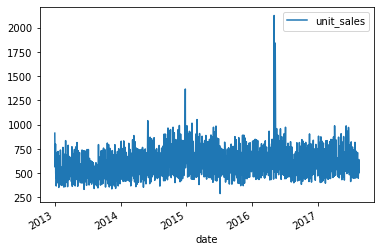

In [12]:
from matplotlib import pyplot
series = total_sales
# display first few rows
print(series.head(5))
# line plot of dataset
series.plot()
pyplot.show()

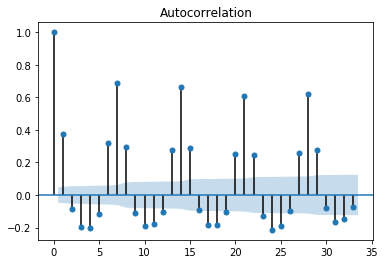

In [13]:
## Autocorrelation Plot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(series)
pyplot.show()

Traditionally, time series features are selected based on their correlation with the output variable.

This is called autocorrelation and involves plotting autocorrelation plots, also called a correlogram. These show the correlation of each lagged observation and whether or not the correlation is statistically significant.

Running the code creates a correlogram, or Autocorrelation Function (ACF) plot, of the data.

The plot shows lag values along the x-axis and correlation on the y-axis between -1 and 1 for negatively and positively correlated lags respectively.

The dots above the blue area indicate statistical significance. The correlation of 1 for the lag value of 0 indicates 100% positive correlation of an observation with itself.

The plot shows significant lag values at 7, 14, 21, 28 days.

## ARIMA
#### To get to know ARIMA model, only use dates and sum of unit sales in the model
#### This would be the ARIMA time series model

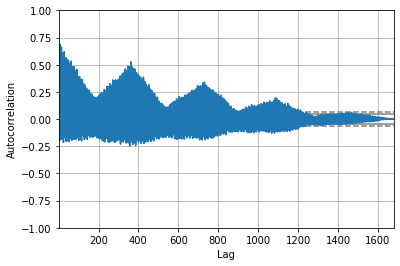

In [22]:
## autocorrelation plot of the time series
## this plots correlations for all days, but we only use 7 in this model for lag order.

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
pyplot.show()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.unit_sales   No. Observations:                 1678
Model:                 ARIMA(7, 1, 0)   Log Likelihood              -10052.986
Method:                       css-mle   S.D. of innovations             96.614
Date:                Fri, 22 Nov 2019   AIC                          20123.972
Time:                        23:32:32   BIC                          20172.800
Sample:                             1   HQIC                         20142.060
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0786      0.475     -0.165      0.869      -1.010       0.853
ar.L1.D.unit_sales    -0.6838      0.024    -27.933      0.000      -0.732      -0.636
ar.L2.D.unit_sales  

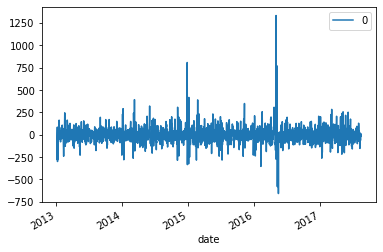

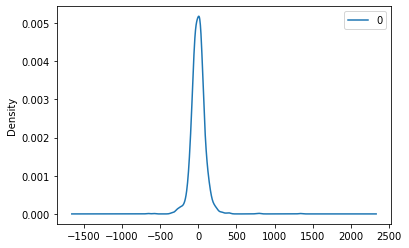

                 0
count  1678.000000
mean     -0.374705
std      97.018012
min    -658.912199
25%     -50.656507
50%      -2.191953
75%      45.731690
max    1332.127901


In [16]:
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(series, order=(7,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

1. model results including the coefficient values

2. Line plot of the residual errors;

3. Density plot of the residual error values;

4. The distribution of the residual errors is displayed.

The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the fut

predicted=598.410855, expected=534.000000
predicted=527.966611, expected=474.000000
predicted=513.783917, expected=576.000000
predicted=485.078244, expected=425.000000
predicted=536.720006, expected=610.000000
predicted=690.841302, expected=678.000000
predicted=671.523605, expected=816.000000
predicted=585.846523, expected=582.000000
predicted=527.922449, expected=497.000000
predicted=529.992861, expected=502.000000
predicted=481.919755, expected=434.000000
predicted=561.498556, expected=569.000000
predicted=684.275374, expected=683.000000
predicted=741.836194, expected=778.000000
predicted=606.773189, expected=601.000000
predicted=526.738421, expected=494.000000
predicted=489.722141, expected=553.000000
predicted=495.547231, expected=385.000000
predicted=525.268504, expected=485.000000
predicted=655.936435, expected=761.000000
predicted=754.677212, expected=846.000000
predicted=627.320339, expected=632.000000
predicted=543.933909, expected=559.000000
predicted=540.003716, expected=628

predicted=540.696106, expected=646.000000
predicted=555.159238, expected=468.000000
predicted=630.122198, expected=705.000000
predicted=783.249946, expected=989.000000
predicted=882.597960, expected=842.000000
predicted=633.495195, expected=595.000000
predicted=551.997328, expected=552.000000
predicted=607.960716, expected=611.000000
predicted=530.383206, expected=478.000000
predicted=693.799553, expected=623.000000
predicted=883.980752, expected=681.000000
predicted=741.129864, expected=843.000000
predicted=638.895211, expected=589.000000
predicted=571.439744, expected=539.000000
predicted=573.498806, expected=625.000000
predicted=548.127895, expected=558.000000
predicted=604.040679, expected=561.000000
predicted=684.756517, expected=575.000000
predicted=733.494820, expected=657.000000
predicted=579.998757, expected=592.000000
predicted=565.194573, expected=524.000000
predicted=589.000512, expected=638.000000
predicted=585.190136, expected=464.000000
predicted=523.410815, expected=615

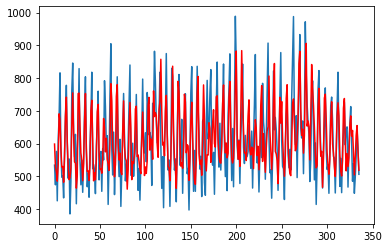

In [17]:
## rolling forecast with the ARIMA model in Python.

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def parser(x):
	return datetime.strptime('210'+x, '%Y-%m')

series = total_sales
X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(7,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Running the example prints the prediction and expected value each iteration.

We can also calculate a final mean squared error score (MSE) for the predictions, providing a point of comparison for other ARIMA configurations.

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

In [18]:
### Mean absolute percentage error (MAPE)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_true = test; y_pred = predictions

mean_absolute_percentage_error(y_true, y_pred)

10.828001467247324